# Урок 6. Сегментация

Попробуйте свои силы в задаче City Scapes на Kaggle - https://www.kaggle.com/dansbecker/cityscapes-image-pairs.

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = '/content/drive/My Drive/GeekBrains/NeuralNetworkIntro/val/'

In [4]:
import os, fnmatch
imag = os.listdir(PATH)

In [5]:
images = []
image_size = (256, 512)
for i_name in imag:
  images.append(image.load_img(PATH+i_name, target_size = image_size))

Скачаем и посмотрим картинки:

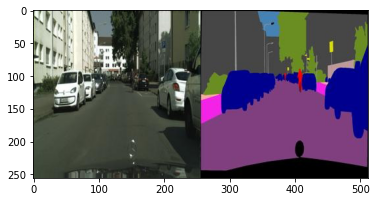

In [6]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Как видно, картинка и разметка у нас соединены в одну картинку. Будем разъединять

In [7]:
X = []

for img in images[:250]: # Больше в память не влазит при обучении нейросети
  x = image.img_to_array(img)
  X.append(x)

X = np.array(X)

In [8]:
X.shape

(250, 256, 512, 3)

Разделяем набор на картинки и разметки

In [9]:
X, y_img = X[:, :, :256, :], X[:, :, 256:, :]

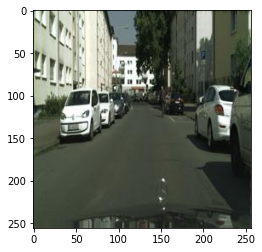

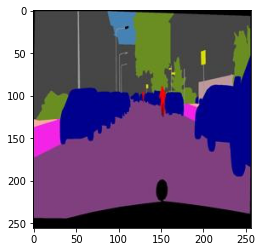

In [10]:
plt.imshow(X[0]/255)
plt.show()
plt.imshow(y_img[0]/255)
plt.show()

Теперь нужно создать слои с разметкой (one hot). С данным набором данных все усложняется, так как цвета целевой разметки неоднородны, видимо, из-за обработки с потерей. Поэтому целевые классы будем определять в некотором диапазоне цветов. В функции Color2index будет параметр align, который будет отвечать за ширину диапазона по каждому каналу.

In [11]:
def Color2index(y, align=5):
  #y - входное изображение разметки (УхХхС - цветное )
  # карту цветов y_ind
  # карту ответов one-hot-encoding y_cat

  # список актуальных цветов разметки
  arr_col=[[0,  0,  0], [111, 74,  0], [81,  0, 81], [128, 64, 128],
           [244, 35, 232], [250, 170, 160], [230, 150, 140], [70, 70, 70],
           [102, 102, 156], [190, 153, 153], [180, 165, 180], [150, 100, 100],
           [150, 120, 90], [153, 153, 153], [250,170, 30], [220, 220, 0],
           [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
           [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90],
           [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    #найдем все точки цвета i_color
    ind_i = np.where((y[:,:,0] <= i_color[0]+align) & (y[:,:,0] >= i_color[0]-align) 
    & (y[:,:,1] <= i_color[1]+align) & (y[:,:,1] >= i_color[1]-align)
    & (y[:,:,2] <= i_color[2]+align) & (y[:,:,2] >= i_color[2]-align)
    & (y_ind[:,:] == 0)) # Не даем пересекаться классам
    
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1

Проверим качество разметки при разных значениях align:

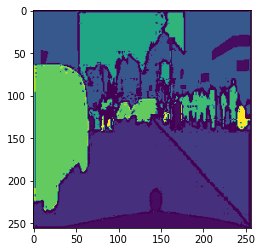

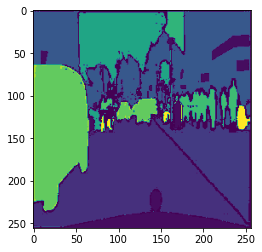

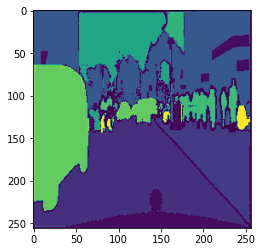

In [12]:
for al in [15, 20, 25]:
  cat_yi,ind_yi,h = Color2index(y_img[8], al)
  plt.imshow(ind_yi.astype(float)/h)
  plt.show() 

При align=25 в разметке меньше всего шума, но некоторые объекты, такие как люди, размечены очень плохо. Но имеем, что имеем

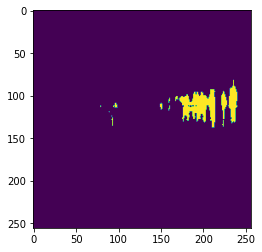

In [13]:
plt.imshow(cat_yi[:,:,19]) # Люди
plt.show()

In [14]:
# road - 3
# sidewalk - 4
# buildings - 7
# vegetation - 16
# sky - 18
# people - 19
# car - 21
# bicycle - 28

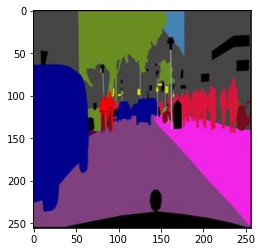

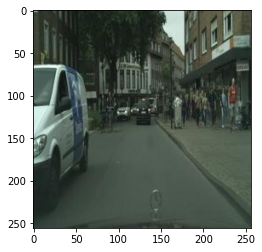

In [15]:
plt.imshow(y_img[8]/255)
plt.show()
plt.imshow(X[8]/255)
plt.show()

Соберем разметку на каждый класс:

In [16]:
y = []

for seg in y_img:
  y_cat, a, b = Color2index(seg, align=25)
  y_cat = y_cat.astype('int8') # Без этого заканчивается память
  y.append(y_cat)
  del y_cat, a, b

y = np.array(y)
y = y.astype('float64')

In [17]:
y.shape

(250, 256, 256, 29)

Разобьем на трейн и тест

In [18]:
N = 200
yTrain = y[:N,:,:,:]
xTrain = X[:N,:,:,:]

yTest = y[N:,:,:,:]
xTest = X[N:,:,:,:]

Загрузим предобученную модель:

In [19]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

In [20]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
def bloc_transpose(x,block_out, numb_filter = [256,128], up=True):
  #x, - input tensor
  #block_out, - scip tensor
  #numb_filter = [256,128] - number of kernel in layers
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  if up:
    x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  return x

In [22]:
def unet_pre_train(num_classes=29, input_shape=(256, 256, 3), pre_trained_model=None, pretrain_out=18, list_bloc = [17, 13, 9, 5, 2]):    
    if pre_trained_model != None:
      for layer in pre_trained_model.layers[:len(pre_trained_model.layers)]:
        layer.trainable = False
      x = pre_trained_model.layers[pretrain_out].output # конец сверток
      block_out = [pre_trained_model.layers[i].output for i in list_bloc]
     
      img_input = pre_trained_model.inputs
      print(block_out[0])
      # первое уменьшение размера
    else:
      return None  
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_out[0]])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    up = True
    for i,block_i in enumerate(block_out[1:]):
      if i == 3:
        up = False
      x = bloc_transpose(x, block_i, numb_filter = [512 // 2**i, 256// 2**i], up=up)

    # x = Conv2D(64, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Соберем U-Net с предобученным энкодером и своими повыщающими слоями:

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='block5_conv3/Relu:0', description="created by layer 'block5_conv3'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)      

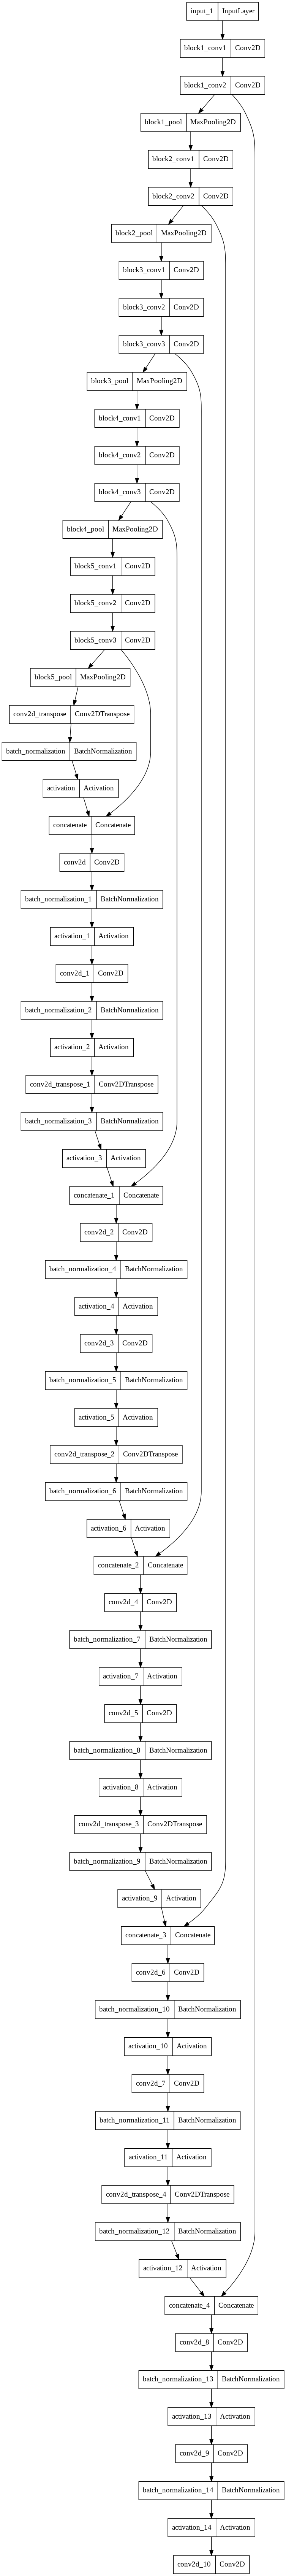

In [23]:
modelU = unet_pre_train(num_classes=29, input_shape=(256, 256, 3), pre_trained_model=pre_trained_model)

plot_model(modelU, to_file='modelU.png')

Свой класс обратного вызова, показывает слои с дорогой, деревьями, зданиями и машинами:

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('\nPredict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for idx, i in enumerate([3, 7, 16, 21]):
      plt.subplot(1,k+1,idx+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for idx, i in enumerate([3, 7, 16, 21]):
      plt.subplot(1,k+1,idx+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 1.5141 - dice_coef: 0.3696
Predict


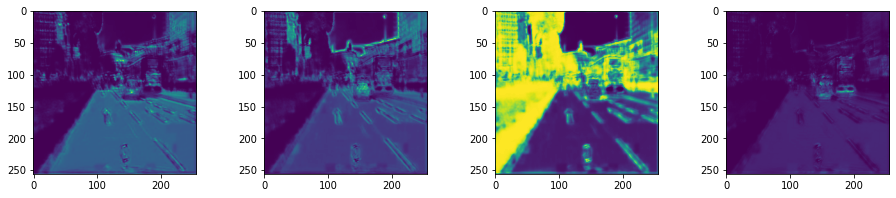

True


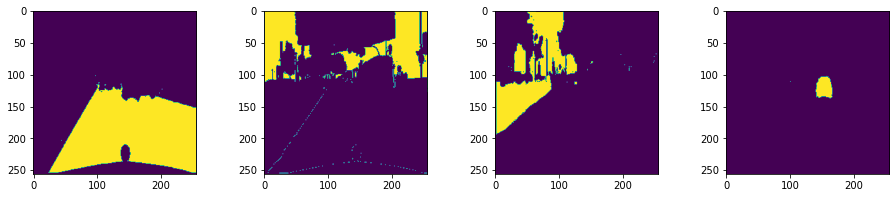


Sample Prediction after epoch 1

40/40 [==============================] - 88s 2s/step - loss: 1.5141 - dice_coef: 0.3696 - val_loss: 2.2327 - val_dice_coef: 0.2212
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.0960 - dice_coef: 0.4814
Predict


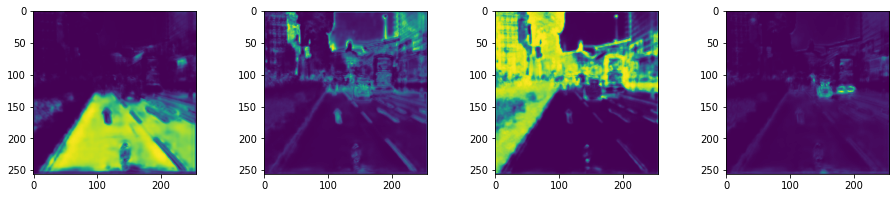

True


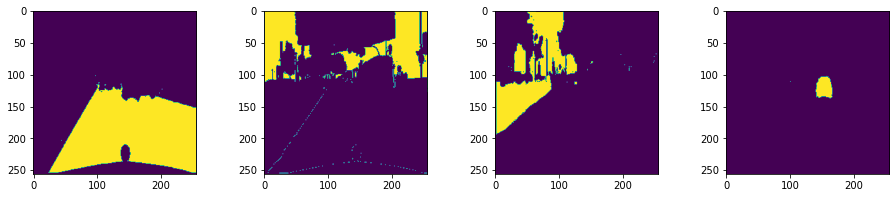


Sample Prediction after epoch 2

40/40 [==============================] - 60s 2s/step - loss: 1.0960 - dice_coef: 0.4814 - val_loss: 1.6895 - val_dice_coef: 0.3328
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 1.0064 - dice_coef: 0.5106
Predict


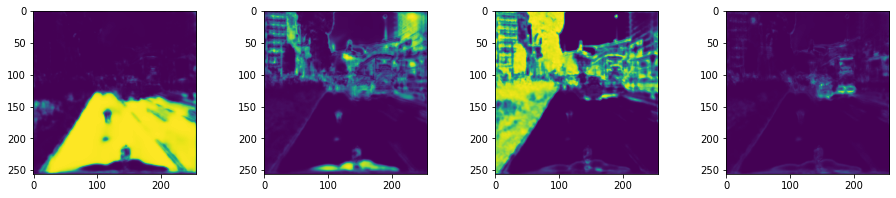

True


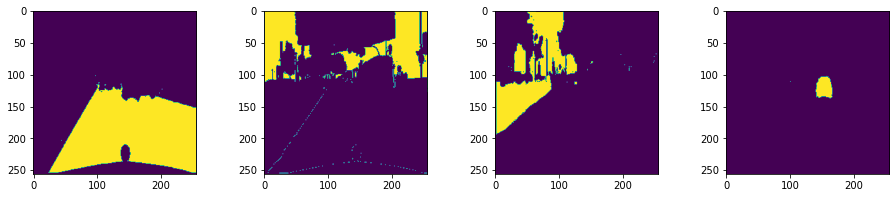


Sample Prediction after epoch 3

40/40 [==============================] - 60s 2s/step - loss: 1.0064 - dice_coef: 0.5106 - val_loss: 1.1613 - val_dice_coef: 0.5409
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 0.9473 - dice_coef: 0.5397
Predict


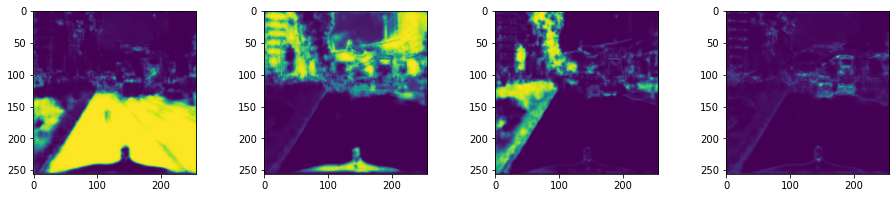

True


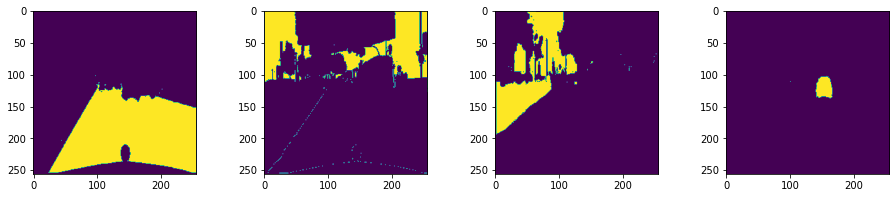


Sample Prediction after epoch 4

40/40 [==============================] - 60s 2s/step - loss: 0.9473 - dice_coef: 0.5397 - val_loss: 1.0638 - val_dice_coef: 0.5936
Epoch 5/30
40/40 [==============================] - ETA: 0s - loss: 0.9258 - dice_coef: 0.5473
Predict


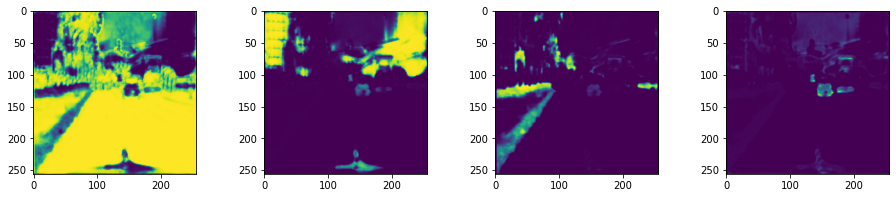

True


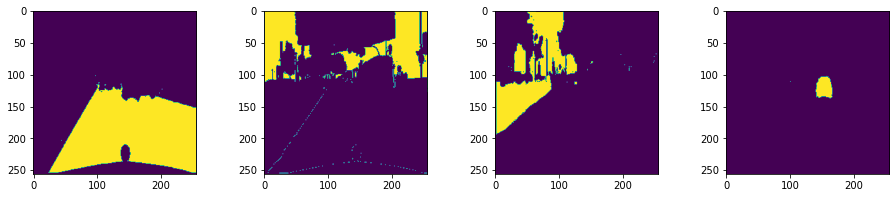


Sample Prediction after epoch 5

40/40 [==============================] - 58s 1s/step - loss: 0.9258 - dice_coef: 0.5473 - val_loss: 2.5476 - val_dice_coef: 0.5291
Epoch 6/30
40/40 [==============================] - ETA: 0s - loss: 0.9728 - dice_coef: 0.5282
Predict


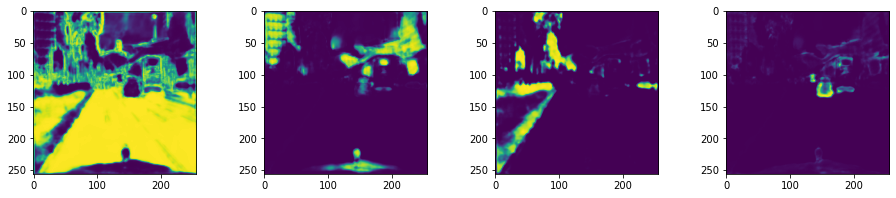

True


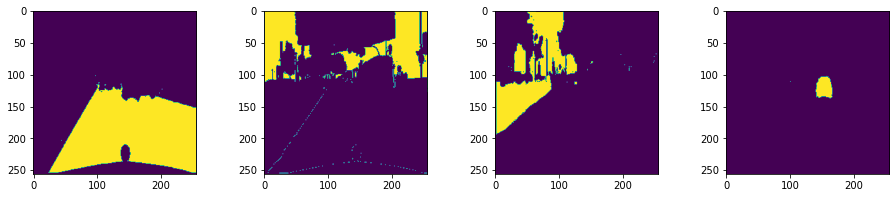


Sample Prediction after epoch 6

40/40 [==============================] - 58s 1s/step - loss: 0.9728 - dice_coef: 0.5282 - val_loss: 1.7610 - val_dice_coef: 0.5606
Epoch 7/30
40/40 [==============================] - ETA: 0s - loss: 0.9451 - dice_coef: 0.5343
Predict


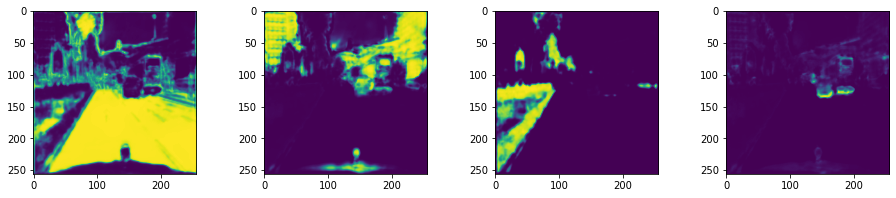

True


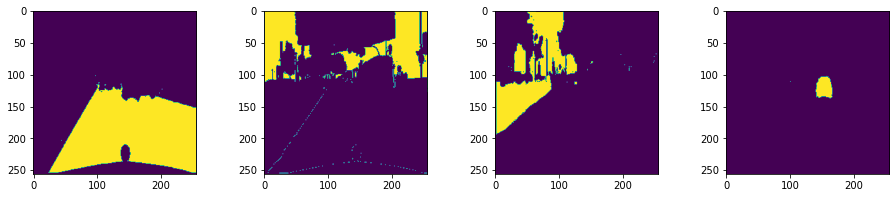


Sample Prediction after epoch 7

40/40 [==============================] - 58s 1s/step - loss: 0.9451 - dice_coef: 0.5343 - val_loss: 1.5570 - val_dice_coef: 0.5693
Epoch 8/30
40/40 [==============================] - ETA: 0s - loss: 0.9284 - dice_coef: 0.5426
Predict


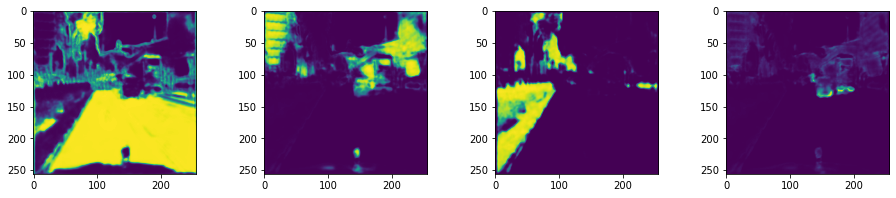

True


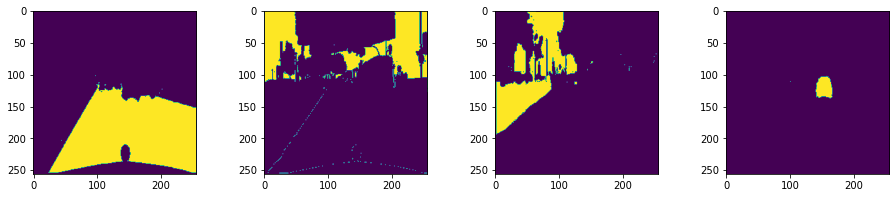


Sample Prediction after epoch 8

40/40 [==============================] - 58s 1s/step - loss: 0.9284 - dice_coef: 0.5426 - val_loss: 1.3501 - val_dice_coef: 0.5959
Epoch 9/30
40/40 [==============================] - ETA: 0s - loss: 0.9497 - dice_coef: 0.5426
Predict


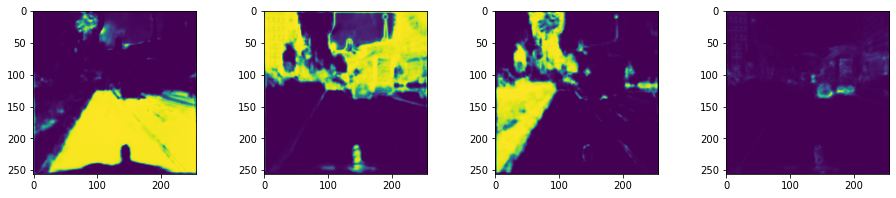

True


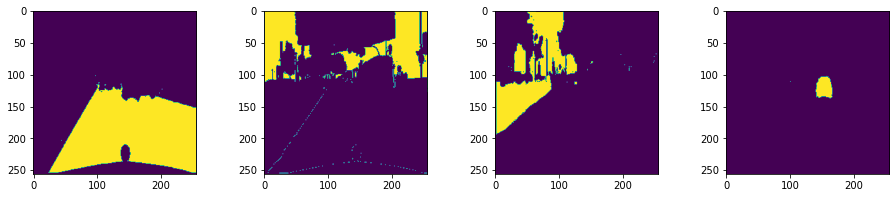


Sample Prediction after epoch 9

40/40 [==============================] - 60s 2s/step - loss: 0.9497 - dice_coef: 0.5426 - val_loss: 1.2459 - val_dice_coef: 0.6635


In [25]:
history = modelU.fit(xTrain, yTrain, epochs = 30, batch_size = 5, validation_data = (xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping(patience=5 ), DisplayCallback()])

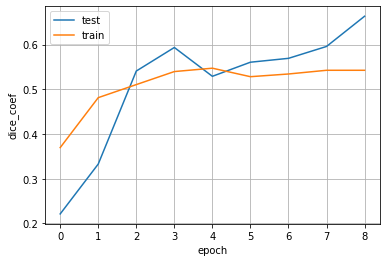

In [26]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

In [34]:
predu = modelU.predict(xTest[:10])
print(predu.shape)

(10, 256, 256, 29)


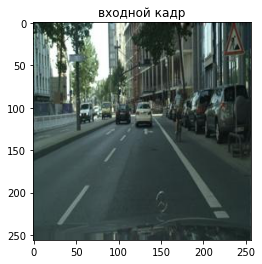

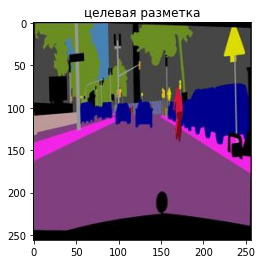

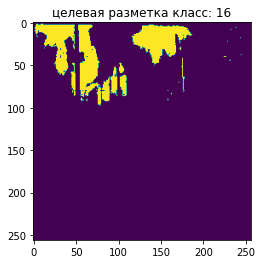

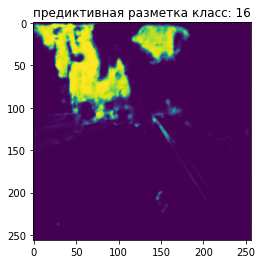

In [42]:
n = 8
class_ = 16 # 3, 7, 16, 21, 19
plt.imshow(xTest[n]/255)
plt.title('входной кадр')
plt.show()
plt.imshow(y_img[N + n]/255)
plt.title('целевая разметка')
plt.show()
img = yTest[n, :,:,class_]
plt.imshow(img)
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n, :,:,class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Посмотрим, как модель справляется с основными классами: дорогой, строениями, деревьями, машинами и людьми

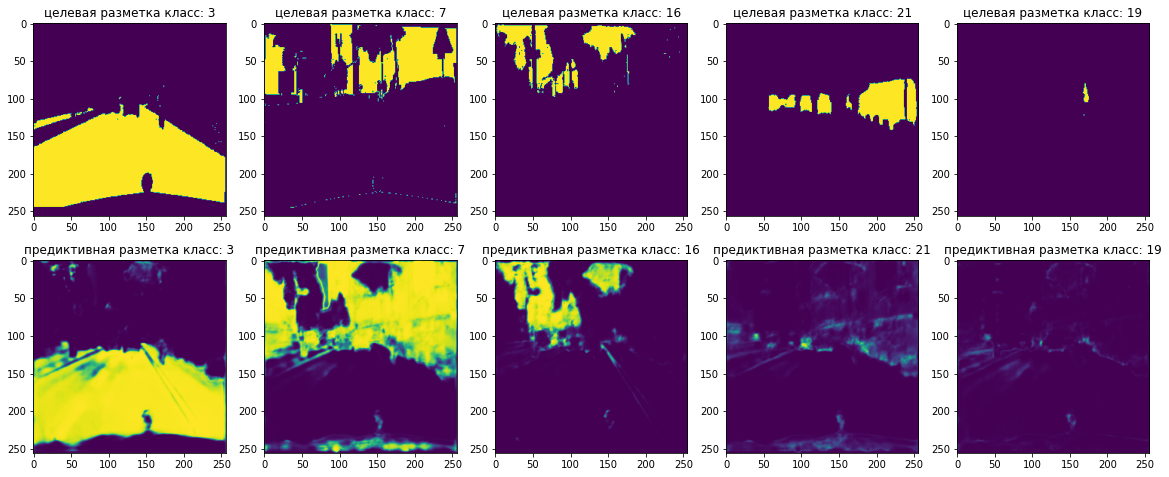

In [58]:
plt.figure(figsize = (20,8))
for idx, class_ in enumerate([3, 7, 16, 21, 19]):
  img = yTest[n, :,:,class_]
  plt.subplot(2, 5, idx+1)
  plt.imshow(img)
  plt.title('целевая разметка класс: '+str(class_))
# plt.show()
# for idx, class_ in enumerate([3, 7, 16, 21, 19]):
  img = predu[n, :,:,class_]
  plt.subplot(2, 5, idx+6)
  plt.imshow(img)
  plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

## Выводы по работе модели:



*   Дорогу и деревья сеть выделяет довольно хорошо
*   Здания выделяет тоже неплохо, но смешивает их с машинами
*   Выделять машины и людей у сети не получается совсем
*   Возможно, это происходит из-за некачественной разметки. Также может стоить обучать на машины и людей отдельно
*   Также хорошо бы обучить на большем количестве данных, но больше 250 картинок не влезает в оперативку при обучении




